In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import io
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Project Prompt

Your IT department has been struggling with an onslaught of malware of different types for the past several months, painstakingly grouped into a few types. Now, one of their data centers has gone down, and they believe it's due to the same malware. But it takes weeks to sort out what kind they've been hit with. The CIO heard that you took DATA 602 and asked for your help. You've been given a dataset of the features the CERT has developed so far, and the associated malware family IDs. 

The CIO has the following goals for you:
1. Can you develop a classifier based on this data, and will it be able to give us an accurate estimate of which malware family has just taken down our data center? 
2. What can you tell the CIO about what has already been found and processed by the CERT? All of the feature creation and labeling is expensive! 

Like many real-world projects, you've been thrown into this with no documentation, and no information about the data or its quality. You've meet two people from the CERT doing this work. One was pretty sharp, and the other seemed like their dad must have gotten them the job... worse, the person who developed the features quit last week. 

For this exam, it is intentionally free-form. Simply building a model won't be sufficient. You need to have a report (i.e., this notebook!) for the CIO on what you've done, why you think it will work, weaknesses & strengths of what you've done. This exam is intentionally vague and open ended.

You can download the exam csv [here](https://www.dropbox.com/s/skrdvxl9xt58ucm/data602_exam.csv?dl=0). 



## Introduction

The CERT team has collected 4999 instances of malware attacks in the company and managed to classify them into 9 classes of malwares.

From their initial analysis, malware type 3 has the maximum reccurances. It constitutes almost 27% of the attacks.

The dataset provided by the CERT is extremely complex and huge. It has 1805 features including the malware class named 'target'. We have to implement a lot of preprocessing in order to get a satisfactory model for the malware detection.

In [2]:
#You may find useful to do this on your own local computer to iterate faster,
#but make sure you can transfer your notebook online and that it works when done! 
data = pd.read_csv('malware_data.csv')

In [3]:
data.head()

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,LONG,BOOL,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,target
0,3.0,3.0,689.0,18.000000,6.0,890.0,6.000000,39.0,17.000000,88.0,...,-208196.847822,149454.443336,330552.774213,133907.410063,44038.800343,55156.067737,-77588.974897,171979.000000,162674.0,2
1,3.0,3.0,583.0,15.000000,5.0,1574.0,8640.382774,6.0,7.000000,30.0,...,36209.864030,221318.549792,-1568.194718,22651.037591,-144906.975987,-33489.566102,157701.356695,7702.000000,6551.0,8
2,3.0,4.0,2796.0,15.000000,5.0,625.0,5.000000,58.0,11.000000,152.0,...,88398.670923,66550.556919,5404.362294,13947.925003,-48559.885445,257023.562444,-204889.973046,151324.169975,12946.0,6
3,3.0,3.0,373.0,2726.071722,9.0,615.0,9.000000,16.0,98583.277889,34.0,...,-157101.258148,-60336.395075,157629.928962,117458.409503,62076.273381,98733.489947,-51461.636374,122247.000000,98621.0,4
4,3.0,3.0,77.0,12.000000,4.0,66.0,91945.635853,3.0,0.000000,5.0,...,32595.648968,-228909.737896,-87033.363460,131606.196188,-118625.690367,89326.297602,-84991.427204,15501.000000,11864.0,1


## 1) Exploratory Data Analysis

##### Identify the variables (features) and their data types

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Columns: 1805 entries, Virtual to target
dtypes: float64(1804), int64(1)
memory usage: 68.8 MB


All the features in the data set are numeric.
There are 1804 float features and one integer feature.

In [5]:
i=0
for type in data.dtypes:
    i+=1
    if type != 'float':
        print(data.iloc[0:0,i-1:i],type)

Empty DataFrame
Columns: [target]
Index: [] int64


The target column(probably integer encoded into the type of malwares)

The different categories and their respective counts are extracted below

In [6]:
data['target'].value_counts().sort_index()

target
1     696
2    1060
3    1344
4     233
5      72
6     371
7     192
8     559
9     472
Name: count, dtype: int64

<Axes: xlabel='target'>

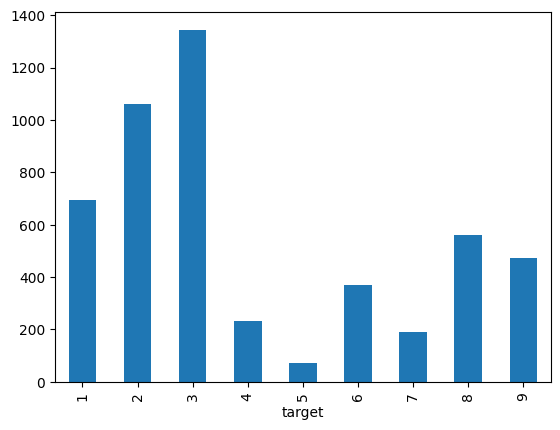

In [7]:
data['target'].value_counts().sort_index().plot(kind = 'bar')

##### Check for missing values and handle them appropriately

In [8]:
data.isnull().sum()

Virtual    0
Offset     0
loc        0
Import     0
Imports    0
          ..
Img104     0
Img105     0
Img106     0
Img107     0
target     0
Length: 1805, dtype: int64

In [9]:
print("The sum of missing/null values in the data set: ",sum(data.isnull().sum()))

The sum of missing/null values in the data set:  0


##### There exists no missing values. Therefore, we need not worry about those in this data set

##### Analyze the distribution of each variable and look for any outliers

Look at the statistic metrics of each column using the describe function.

Since, the dataframe is too large to observe on teh notebook, it is saved as a csv file for manual study.

In [10]:
data.describe().to_csv('describe.csv')

We find that there a lot of zeroes in the data set. Let us see a count of zeroes and see if those columns are relevant compared to the total number of rows.

In [11]:
zero = (data == 0)
num_zeroes = dict(zero.sum())
#print(num_zeroes)

In [12]:
for column in num_zeroes.keys():
    zero_count = num_zeroes.get(column)
    if(zero_count > 1400):
         data.drop(column, axis = 1, inplace = True)

In [13]:
data.shape

(4999, 722)

In [14]:
data.describe().to_csv('describe_new.csv')

We have removed the features that have too many entries as zero.

The lower limit is chosen as 1400 because there are 1344 entries of a single type of malware. Therefore, it won't affect the data even if that feature is supposed to be zero for a malware class.

There are 722 features to be studied and is therefore expensive to analyse using histograms and boxplots.

We will look into the zscores and interquartile ranges to identify the outliers and handle them

In [15]:
# for col_index, col in enumerate(data.columns):
#     print(col_index, col)

In [16]:
def zscores_metric(data,threshold = 2):
    z_scores = pd.DataFrame(stats.zscore(data))
    #print(z_scores)
    outlier_indices = {}
    for col_index, col in enumerate(data.columns):
        col_zscores = z_scores.iloc[col_index]
        col_outliers_indices = list(filter(lambda i:abs(col_zscores[i]) > threshold, range(len(col_zscores))))
        outlier_indices[col] = col_outliers_indices
    return outlier_indices

In [17]:
Z_outliers_dict = zscores_metric(data)
#Z_outliers_dict # this is a dictionary of the format - {'col_name':'row_index'}

/var/folders/c0/f1s_z1s10db9z5zsf0wzj1yw0000gn/T/ipykernel_18842/694585764.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_outliers_indices = list(filter(lambda i:abs(col_zscores[i]) > threshold, range(len(col_zscores))))


We remove the outliers

In [18]:
# This function removes an entire column if the number of outliers is greater than 1400
# it is because, 1344 is the count of the highest malware class
def remove_zscore_outliers_col(zscore_outliers, data):
    #data_new = pd.DataFrame(data)
    for col in zscore_outliers.keys():
        if len(zscore_outliers.get(col))>= 1400:
             data.drop(col, axis = 1, inplace = True)
    return data

In [19]:
# First, the columns are removed followed by the rows
new_data = remove_zscore_outliers_col(Z_outliers_dict,data)
data_new = pd.DataFrame(new_data, columns = Z_outliers_dict.keys())
#print(data_new)

In [20]:
data_new.reset_index(drop = True, inplace = True)

In [21]:
data_new.shape

(4999, 722)

In [22]:
def iqr_metric(data, factor = 2):
    outlier_indices_iqr = {}
    for column in data_new.columns:
        column_data = data_new[column]
        q1 = column_data.quantile(0.25)
        q3 = column_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        column_outliers_indices = column_data[(column_data < lower_bound) | (column_data > upper_bound)].index.tolist()
        outlier_indices_iqr[column] = column_outliers_indices
    
    return outlier_indices_iqr

In [23]:
iqr_outliers_dict = iqr_metric(data_new)
#iqr_outliers_dict

In [24]:
#This function remvoes the rows with values beyond 1.5 times the IQR
def remove_iqr_outliers(iqr_outliers, data):
    outlier_indices = set()
    data_new = pd.DataFrame(data)
    for outliers in iqr_outliers.values():
        if len(outliers) >= 300:
            outlier_indices.update(outliers)
    data_new = data_new.drop(index = outlier_indices)
    return data_new

In [25]:
data_new_1 = remove_iqr_outliers(iqr_outliers_dict, data)
data_new.reset_index(drop = True, inplace = True)

In [26]:
data_new_1.shape

(0, 722)

Applying interquartile range to remove the outliers is not a good idea for this data set. When we give a closer look at the describe_new.csv file, we observe that the min and max are too far apart, whereas the 25th and 75th percentile are closer.

As a result the data set will be wiped off if we apply the filter with a reasonable factor.

Therefore, we will work on the data set with 722 features and 4999 rows - data_new

##### Visualize the data using plots and charts to gain insights

<b>Selected Correlation Heat Map</b>: The heat of correlation matrix among highly correlated above 0.8 (negative and positive) features are plotted

In [28]:
corr_matrix = data_new.corr()

In [29]:
corr_matrix.head()

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,BOOL,BYTES,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,target
Virtual,1.000000,-0.004551,-0.013496,0.008869,-0.011001,-0.003866,0.022367,-0.002178,-0.003944,-0.002494,...,-0.010322,-0.022041,-0.005017,-0.011999,0.017922,0.023604,-0.000599,-0.010150,-0.020290,0.016836
Offset,-0.004551,1.000000,-0.003492,0.028743,-0.036971,0.003167,0.008605,-0.010113,-0.014884,-0.000236,...,-0.005274,0.006346,-0.003801,-0.001266,0.001590,0.011894,0.008447,-0.016792,-0.017473,-0.015497
loc,-0.013496,-0.003492,1.000000,0.046483,0.010628,0.123093,0.013365,-0.027305,-0.005929,0.009719,...,0.003408,0.007975,0.006328,0.011233,0.023272,0.006724,-0.011959,0.000677,-0.019090,-0.069736
Import,0.008869,0.028743,0.046483,1.000000,0.035753,-0.010220,-0.003489,-0.001147,-0.014568,-0.009965,...,-0.019242,0.038166,0.001456,-0.016329,-0.005756,-0.024268,-0.019246,0.009534,0.000194,0.003007
Imports,-0.011001,-0.036971,0.010628,0.035753,1.000000,-0.020269,-0.006008,-0.008402,-0.023370,-0.001776,...,-0.004768,0.007280,0.012975,0.007917,-0.001575,-0.001689,0.012516,0.009267,0.012227,-0.011463


In [30]:
corr_threshold = corr_matrix.where(corr_matrix.abs() >= 0.8)
corr_threshold.values[[i for i in range(len(corr_threshold))], [i for i in range(len(corr_threshold))]] = float('nan')
corr_threshold

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,BOOL,BYTES,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,target
Virtual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Offset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Import,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Imports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Img104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Img105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Img106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.943207,NaN
Img107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.943207,NaN,NaN


In [31]:
corr_pairs_indices = corr_threshold.stack().index[corr_threshold.stack().notna()]
print(corr_pairs_indices)

MultiIndex([(                  'db', 'section_names_.rdata'),
            (                  'db',        'ExtendedAscii'),
            ('section_names_.rdata',                   'db'),
            (            'FileSize',       'line_count_asm'),
            (            'FileSize',             'size_asm'),
            (      'line_count_asm',             'FileSize'),
            (      'line_count_asm',             'size_asm'),
            (            'size_asm',             'FileSize'),
            (            'size_asm',       'line_count_asm'),
            (       'ExtendedAscii',                   'db'),
            (              'Img106',               'Img107'),
            (              'Img107',               'Img106')],
           )


In [32]:
len(corr_pairs_indices)

12

In [33]:
i=0

pair_1 = []
pair_2 = []
for i in range(0,len(corr_pairs_indices)):
    row_pairs = corr_pairs_indices[i]
    pair_1.append(row_pairs[0])
    pair_2.append(row_pairs[1])

In [34]:
pair_1

['db',
 'db',
 'section_names_.rdata',
 'FileSize',
 'FileSize',
 'line_count_asm',
 'line_count_asm',
 'size_asm',
 'size_asm',
 'ExtendedAscii',
 'Img106',
 'Img107']

In [35]:
heatmap_data = pd.DataFrame(index=pair_1, columns=pair_2)
for row, col in zip(pair_1,pair_2):
    heatmap_data.at[row, col] = corr_threshold.at[row, col]
heatmap_data

,section_names_.rdata,ExtendedAscii,db,line_count_asm,size_asm,FileSize,size_asm,FileSize,line_count_asm,db,Img107,Img106
db,0.828119,0.937598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
db,0.828119,0.937598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
section_names_.rdata,NaN,NaN,0.828119,NaN,NaN,NaN,NaN,NaN,NaN,0.828119,NaN,NaN
FileSize,NaN,NaN,NaN,0.981264,0.99999,NaN,0.99999,NaN,0.981264,NaN,NaN,NaN
FileSize,NaN,NaN,NaN,0.981264,0.99999,NaN,0.99999,NaN,0.981264,NaN,NaN,NaN
line_count_asm,NaN,NaN,NaN,NaN,0.981271,0.981264,0.981271,0.981264,NaN,NaN,NaN,NaN
line_count_asm,NaN,NaN,NaN,NaN,0.981271,0.981264,0.981271,0.981264,NaN,NaN,NaN,NaN
size_asm,NaN,NaN,NaN,0.981271,NaN,0.99999,NaN,0.99999,0.981271,NaN,NaN,NaN
size_asm,NaN,NaN,NaN,0.981271,NaN,0.99999,NaN,0.99999,0.981271,NaN,NaN,NaN
ExtendedAscii,NaN,NaN,0.937598,NaN,NaN,NaN,NaN,NaN,NaN,0.937598,NaN,NaN


In [36]:
heatmap = heatmap_data.fillna(0)

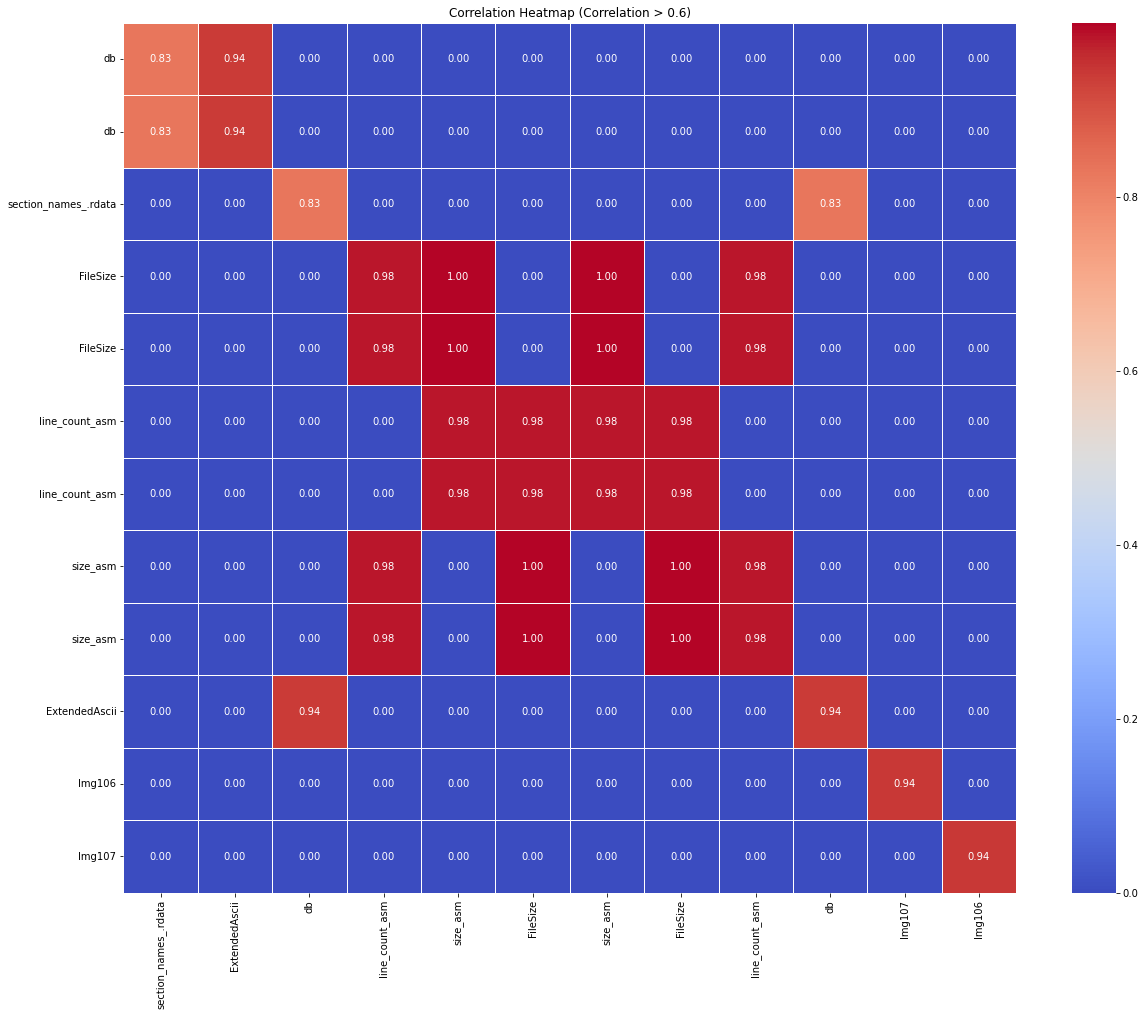

In [37]:
plt.figure(figsize=(20, 16))
sns.heatmap(heatmap, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(f'Correlation Heatmap (Correlation > 0.6)')
plt.show()

In [38]:
plt.savefig('heatmap.png', dpi=300)

<Figure size 432x288 with 0 Axes>

Using the heatmap, we can observe that a few of the features are correlated with an absolute value greater than 0.8.

In this heatmap, the blue color represents those with correlation lesser than 0.8.

This enables us to extract a few features that can be used for bivariate or multivariate analysis.

##### tSNE Visualization

In [39]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2).fit_transform(data_new)
tsne_df = pd.DataFrame(tsne)
tsne_df.index = data_new.index.tolist()
tsne_df.columns = ['Component 1','Component 2']
data_new_indices = data_new.target.iloc[data_new.index.tolist()]
tsne_df = pd.concat([tsne_df, data_new_indices], axis=1)
tsne_df.head()

,Component 1,Component 2,target
0,36.831692,-22.732267,2
1,-3.660364,16.421091,8
2,66.367836,-1.559113,6
3,19.148952,0.697873,4
4,19.435099,26.595371,1


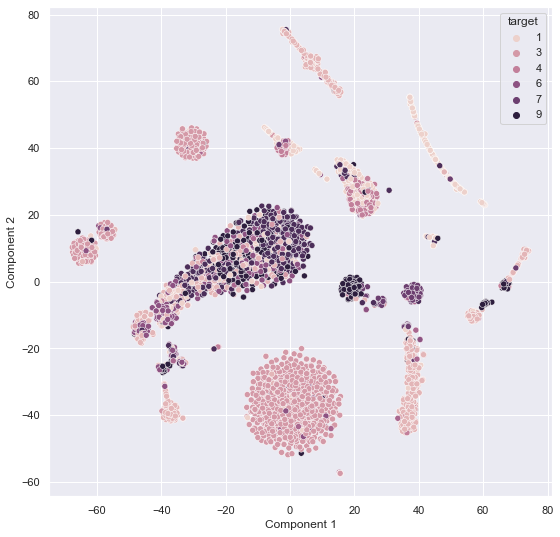

In [40]:
sns.set(rc={'figure.figsize':(9,9)})
sns.scatterplot(x='Component 1', y='Component 2', hue='target', data=tsne_df)
plt.show()

The above scatterplot interprets the following - 
- The malware classes 1,4, and 9 have many common features.
- The malware class 3 has very peculiar characteristics and stands out.

In [92]:
def plot_func(dataA,dataB,A,B):
    plt.figure(figsize = (8,5))
    plt.scatter(dataA, dataB)
    plt.xlabel(A)
    plt.ylabel(B)
    #plt.title(A," vs ", B)
    plt.show()

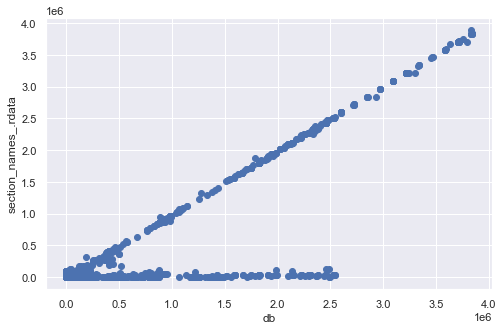

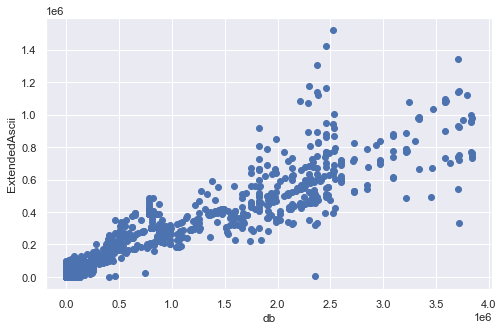

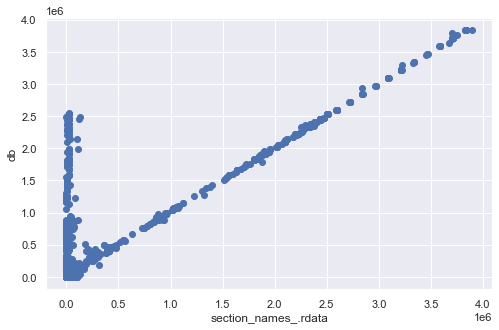

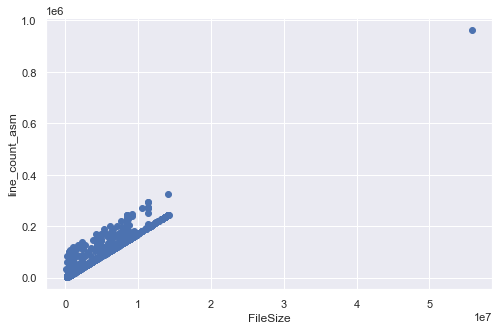

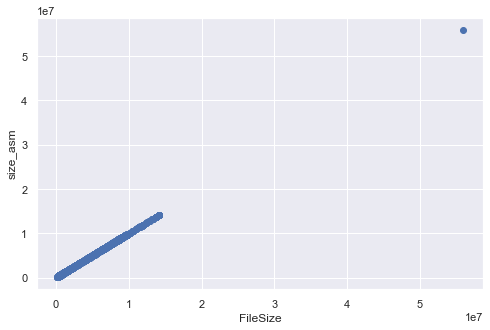

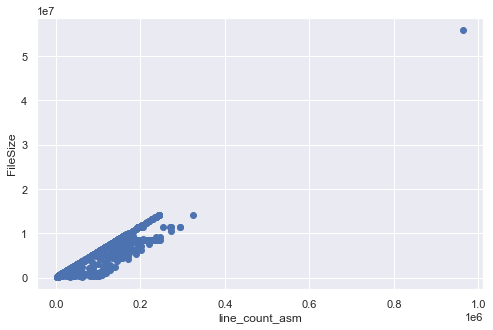

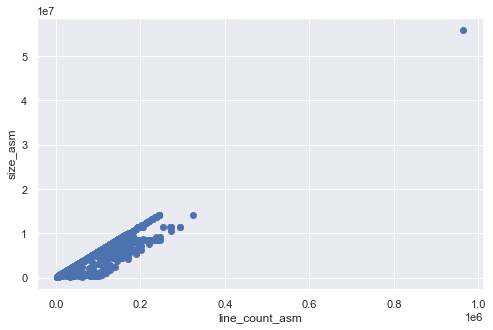

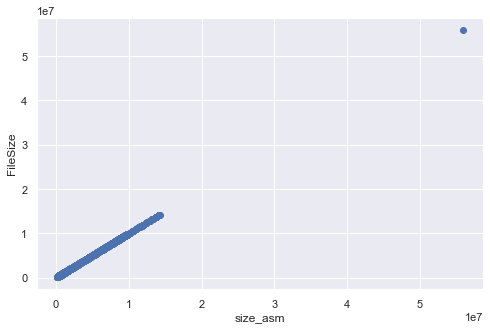

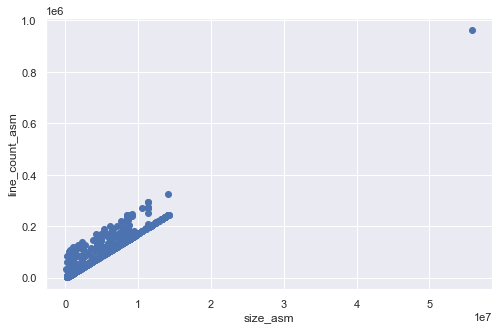

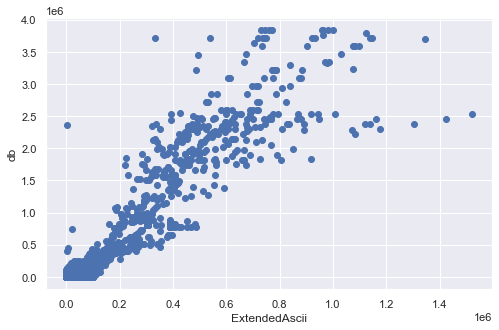

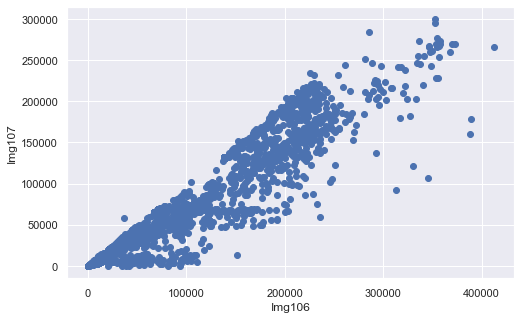

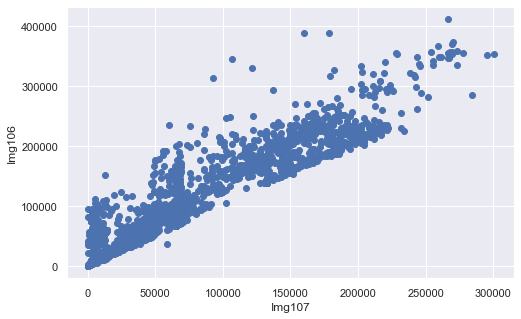

In [93]:
for feat1, feat2 in zip(pair_1,pair_2):
    plot_data_A = pd.DataFrame()
    plot_data_B = pd.DataFrame()
    plot_data_A[feat1] = data_new[feat1]
    plot_data_B[feat2] = data_new[feat2]
    plot_func(plot_data_A,plot_data_B, feat1, feat2)

## 2) Creating a Pipeline

##### Preprocess the data by handling missing values, encoding categorical variables, and scaling numerical features.

We have observed that the data set is free of any missing values or non-numerical variables which need encoding.

We can scale the dataset using the StandardScaler()

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
num_preprocessing = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 10))
])

In [45]:
from sklearn.compose import ColumnTransformer
X = data_new.drop('target', axis=1)
columns = X.select_dtypes(include='number').columns.tolist()
preprocessor = ColumnTransformer([
    ('numerical',num_preprocessing, columns)
])

In [46]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Columns: 722 entries, Virtual to target
dtypes: float64(721), int64(1)
memory usage: 27.5 MB


In [47]:
len(columns)

721

In [48]:
y = data_new['target']

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[columns],y, test_size = 0.3, random_state = 42)

In [50]:
pipeline = Pipeline([
    ('preprocessor',preprocessor)
])

## 3) Applying Machine Learning Models

#### i) Decision Tree Classifier

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
decisiontree_model = DecisionTreeClassifier(random_state = 42)
param_grid_dt = {
    'decision_tree__max_depth': [None, 10, 20, 30],
    'decision_tree__min_samples_split': [5, 10,20],
    'decision_tree__min_samples_leaf': [1, 2, 4]
}
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('decision_tree', decisiontree_model)
])
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_
best_model_dt = grid_search_dt.best_estimator_
y_pred_decision = best_model_dt.predict(X_test)
print(best_params_dt)

{'decision_tree__max_depth': 10, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 20}


In [89]:
y_train_pred_dt = best_model_dt.predict(X_train)
print("Training Accuracy of Decision Tree Model: ",accuracy_score(y_train, y_train_pred_dt) )

Training Accuracy of Decision Tree Model:  0.7310660188625322


In [52]:
zero_division = 1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy_dt = accuracy_score(y_test, y_pred_decision)
precision_dt = precision_score(y_test, y_pred_decision, average = 'weighted',zero_division=zero_division)
recall_dt = recall_score(y_test, y_pred_decision,average = 'weighted',zero_division=zero_division)
f1_dt = f1_score(y_test, y_pred_decision,average = 'weighted',zero_division=zero_division)
print("Decision Tree\nAccuracy: ",accuracy_dt,"\nPrecision: ",precision_dt,"\nRecall: ",
      recall_dt,"\nF1-score: ",f1_dt)

Decision Tree
Accuracy:  0.64 
Precision:  0.6349046006144393 
Recall:  0.64 
F1-score:  0.630244394890468


##### ii) Support Vector Machine

In [54]:
from sklearn.svm import SVC
svm_model = SVC(random_state = 42)
param_grid_svm = {
    'svm__C': [1, 10, 100],
    'svm__kernel': ['linear', 'rbf'],
}
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', svm_model)
])
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)
best_params_svm = grid_search_svm.best_params_
best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(X_test)
print(best_params_svm )

{'svm__C': 1, 'svm__kernel': 'rbf'}


In [90]:
y_train_pred_svm = best_model_svm.predict(X_train)
print("Training Accuracy of SVM Model: ",accuracy_score(y_train, y_train_pred_svm) )

Training Accuracy of SVM Model:  0.7079165475850243


In [55]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average = 'weighted',zero_division=zero_division)
recall_svm = recall_score(y_test, y_pred_svm,average = 'weighted',zero_division=zero_division)
f1_svm = f1_score(y_test, y_pred_svm,average = 'weighted',zero_division=zero_division)
print("Support Vector Classifier\nAccuracy: ",accuracy_svm,"\nPrecision: ",precision_svm,"\nRecall: ",
      recall_svm,"\nF1-score: ",f1_svm)

Support Vector Classifier
Accuracy:  0.6973333333333334 
Precision:  0.7134135574429523 
Recall:  0.6973333333333334 
F1-score:  0.6904362154224523


##### iii) Random Forest Model

In [57]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'random_forest__n_estimators': [100, 200, 300],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4]
}
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', random_forest_model)
])
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
best_model_rf= grid_search_rf.best_estimator_
y_pred_rf =best_model_rf.predict(X_test)
print(best_params_rf)

{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 200}


In [91]:
y_train_pred_rf = best_model_rf.predict(X_train)
print("Training Accuracy of Random Forest Model: ",accuracy_score(y_train, y_train_pred_rf) )

Training Accuracy of Random Forest Model:  0.943126607602172


In [58]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average = 'weighted',zero_division=zero_division)
recall_rf = recall_score(y_test, y_pred_rf,average = 'weighted',zero_division=zero_division)
f1_rf = f1_score(y_test, y_pred_rf,average = 'weighted',zero_division=zero_division)
print("Random Forest Model\nAccuracy: ",accuracy_rf,"\nPrecision: ",precision_rf,"\nRecall: ",
      recall_rf,"\nF1-score: ",f1_rf)

Random Forest Model
Accuracy:  0.696 
Precision:  0.7071859217388774 
Recall:  0.696 
F1-score:  0.6930427280550898


## 4) Comparing the Models and Explaining the Results

In [72]:
Model_perf = pd.DataFrame(index = ['Accuracy', 'Precision','Recall','F1-score'], columns = ['Decision Tree', 'Support Vector Machine', 'Random Forest'])
Model_perf['Decision Tree'] = [accuracy_dt, precision_dt, recall_dt,f1_dt]
Model_perf['Support Vector Machine'] = [accuracy_svm, precision_svm, recall_svm,f1_svm]
Model_perf['Random Forest'] = [accuracy_rf, precision_rf, recall_rf,f1_rf]
Model_perf

,Decision Tree,Support Vector Machine,Random Forest
Accuracy,0.640000,0.697333,0.696000
Precision,0.634905,0.713414,0.707186
Recall,0.640000,0.697333,0.696000
F1-score,0.630244,0.690436,0.693043


##### A pictorial representation of the metrics

In [62]:
models = ['Decision Tree', 'SVM', 'Random Forest']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
accuracy_scores = [accuracy_dt, accuracy_svm, accuracy_rf]
precision_scores = [precision_dt, precision_svm, precision_rf]
recall_scores = [recall_dt, recall_svm, recall_rf]
f1_scores = [f1_dt, f1_svm, f1_rf]
scores = [accuracy_scores, precision_scores, recall_scores, f1_scores]

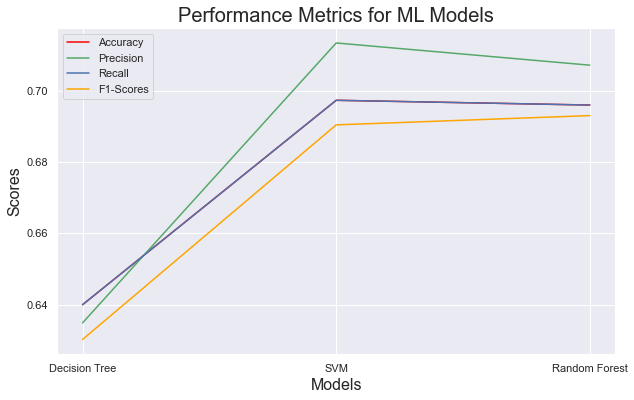

In [83]:
plt.figure(figsize = (10,6))
plt.plot(models,accuracy_scores,label = 'Accuracy',color = 'red')
plt.plot(models,precision_scores, label = 'Precision',color = 'g')
plt.plot(models,recall_scores, label = 'Recall',color = 'b')
plt.plot(models,f1_scores, label = 'F1-Scores',color = 'orange')
plt.title('Performance Metrics for ML Models', fontsize = 20)
plt.legend()
plt.xlabel('Models',fontsize = 16)
plt.ylabel('Scores', fontsize = 16)
plt.show()

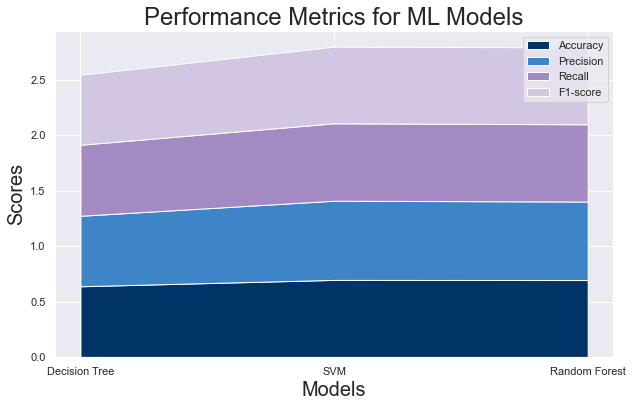

In [74]:
plt.figure(figsize = (10,6))
color_map = ["#003366", "#3d85c6", "#a38ac3", "#d2c6e2"]
plt.stackplot(models, scores,baseline='zero', colors = color_map,labels = metrics)
plt.title('Performance Metrics for ML Models', fontsize = 24)
plt.legend()
plt.xlabel('Models',fontsize = 20)
plt.ylabel('Scores', fontsize = 20)
plt.show()

From the above graph, the following can inferred - 
- Support Vector Machine has the greatest performance among the three models. 
- Random Forest Classifier also have almost the saem level of performance as compared to SVM.
- Both SVM Random Forests are capable of providing a good prediction of the malware class.
- The Decision Tree classifier fails due to the hugedata size and imbalance in the classes

Performance Differences:
- Model Complexity: Random Forest models perform best with noisy data. We have a collection of information poorly labelled and organized. This is an instance when random shuffling of data and features comes in handy for providing the best outcome. Even though SVM also can handle complex decisions, it requires deeper hyperparamter tuning.

- Data Distribution: We are clearly provided with an imbalanced dataset. The malware class '3' and '2' has the greatest share of data and therefore affects the robustness of Decision Tree. The other two models handle such imbalances well and therefore has almost same performance.

- Suitability for the Problem: SVM and Random Forest are suitable for high-dimensional multiclass classification. However, Decision Tree classifier tends to show discrepancy when dealing with complex datasets with multiple classes

## 5) Conclusion

#### Summary of Findings and Performance of models

- The malware <b>class 3</b> is the most identified class from the given data set. Even the models tend to predict the same, however, not with much accuracy. 

- The Support vector machine has the best performance amongst the three deployed models.

- 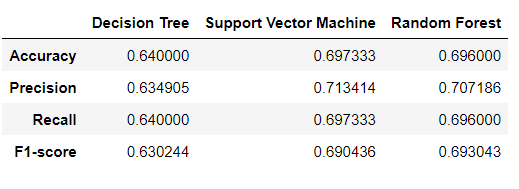

- 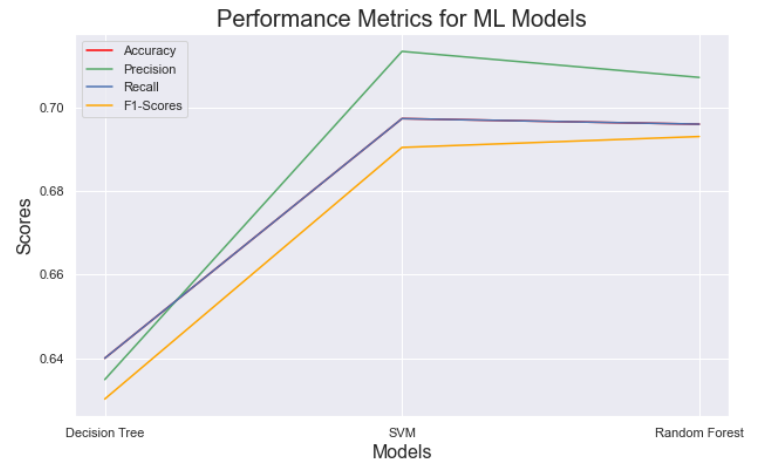

- 12 features show high correlation (greater than 0.8) and 64 of them have a correlation greater than 0.6


- |              |    Train Accuracy   |  Test Accuracy  |
  |--------------|---------------------|-----------------|
  |Decision Tree |        73.1%        |      64.0%      |
  |SVM           |        70.8%        |      69.7%      |
  |Random Forest |        94.3%        |      69.6%      |
  
  We can observe that the random forest classifier has a very high accuracy on train data set which indicates overfitting of the model. The lower accuracy on the test data set is due to this overfitting.

#### Challenges faced

- Dealing with big data is challenging, especially an organized one with no metadata available for understanding the data better.

- The feature 'target' was assumed to be the malware classification for the entire data analysis and machine learning.

- The lack of metadata would have resulted in omission of necessary features which appeared to be outliers in the data set.

- The high standard deviation of the features along with the hige difference in the range of data(max - min) affected teh outler detection using interquartile range. 
 
- The time-constraint restricted from further tuning and analysing of the data. Data cleaning and preprocessing consumed major share of the stipulated time, therefore, modeling is incomplete.
 
- The lack of fine tuning of hyperparameters of the models have resulte in overfitting especially in random forest classifier. 
 
- Computation also was time consuming due to the size of the data. Many times it had to be cut short into a few features especially visualization. 

#### Strengths and Weaknesses of the methods deployed

- Decision Tree Classifier: The direct if-else implementation of a complex and bulky data does not provide with accurate results. A gridsearch cross-validation on the dataset might have helped improve teh accuracy of the model by a few decimal points.
- Support Vector Machine: The high accuracy of SVM lies in its robustness with high-dimensional data and compatibility with imbalanced data. However, the lack of fine tuning hyper parameter tuning has resulted in a lower-than-potential accuracy of the model.
- Random Forest Classifiers: Alike SVM, Random forests also exhibit good perfoemance with high-dimensional and imbalanced data. The random forest will perform better with t-SNE dimensionality reduction than the used PCA.

#### Potential Imporvements and Future Work

- ##### Improvements:
 - <b>Fine Hyperparameter Tuning:</b> The machine learning models require finer tuning of its hyperparameters. This requires better computational resources and more time. SVM and Random forest will showsignificant improvement with fine tuning. However, due to the complexity of the data and high-dimensionality, decision trees would not show much change
 - <b>Data Cleaning:</b> Even though this step was tedious and time-consuming, it was not enough. Proper cleaning based on more domain knowledge and meta data study will improve the quality of the cleaned dataset. There is a good possibility that a few important features were discarded due to lack of data knowledge.
 - <b>Data Preprocessing:</b> In this model preparation, PCA was used to reduce the dimensionality of the data. However, other methods and tuning of PCA components can give better quality of data for modeling.
 - <b>Data Visualization:</b> Due to large number of features, the data visualization was not properly done. Finding the significant features with proper Data cleaning and preprocessing is required for meaningful visualizations.
 - <b>Machine Learning Models:</b> There are more complex machine learning models that could provide better accuracy in the predictions. Even with the current deployed ones, better tuning and preprocessing could imporve teh prediction accuracy.

- ##### Future Work:
 - <b>Malware Tracing:</b> The ML models can be deployed intracing future malware attacks and understanding the class so that the actions can be taken immediately before the attackis irreversible.
 - <b>Malware Protection:</b> The analysis from this project can be further extended to detect malwares even before they are implemented on a system. It can be developed into an anti-virus software. The different features in the data set can be closely observed to identify any malware sources.